### Simple Residual model in Tensorflow

This notebook is simply for testing a resnet-50 inspired model built in Tensorflow on a numerical signs dataset.

In [1]:
import numpy as np
import tensorflow as tf
from keras import backend as K
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Using a signs dataset, with images of numerical signs from 0-9
X = np.load("../../data/sign-digits/X.npy")
y = np.load("../../data/sign-digits/y.npy")
X.shape = (2062, 64, 64, 1)
X = shuffle(X,random_state=0)
y = shuffle(y,random_state=0)
print(X.shape)
print(y.shape)

(2062, 64, 64, 1)
(2062, 10)


In [3]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.05)
print(X_train.shape)
print(X_test.shape)

(1958, 64, 64, 1)
(104, 64, 64, 1)


In [4]:
# Placeholder values for input X,y data
def get_placeholders(x_h,x_w,x_c,n_y):
    """
    x_h: Height for x input 
    x_w: Width for x input
    x_c: Channels for x input
    n_y: shape of y input (None,10)
    """
    X = tf.placeholder(tf.float32, name="X", shape=(None,x_h,x_w,x_c))
    y = tf.placeholder(tf.float32, name="y", shape=(None,n_y))
    return X,y

In [5]:
# Block corresponding with no change in size
def identity_block(the_input, ks, filters, s):
    """
    the_input: activation from the previous layer
    ks: kernel size for the middle layer
    filters: list of number of filters to be used in each block
    s - start: the number of the first layer
    """
    F1,F2,F3 = filters
    old_input = the_input
    # Block 1
    Z1 = tf.layers.conv2d(the_input,filters=F1,kernel_size=[1,1],strides=(1,1),padding="same",name="Z"+str(s),kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    Bn1 = tf.layers.batch_normalization(Z1,name="Bn"+str(s))
    A1 = tf.nn.relu(Bn1,name="A"+str(s))
    # Block 2
    Z2 = tf.layers.conv2d(A1,filters=F2,kernel_size=[ks,ks],strides=(1,1),padding="same",name="Z"+str(s+1),kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    Bn2 = tf.layers.batch_normalization(Z2,name="Bn"+str(s+1))
    A2 = tf.nn.relu(Bn2,name="A"+str(s+1))
    # Block 3
    Z3 = tf.layers.conv2d(A2,filters=F3,kernel_size=[1,1],strides=(1,1),padding="same",name="Z"+str(s+2),kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    Bn3 = tf.layers.batch_normalization(Z3,name="Bn"+str(s+2))
    # Add old activation
    res = tf.add(Bn3,old_input,name="resid_add"+str(s+2))
    A3 = tf.nn.relu(res,name="A"+str(s+2))
    
    return A3

In [6]:
# Block corresponding with a change in size
def conv_block(the_input,ks, filters, s, stride):
    """
    the_input: activation from the previous layer
    ks: kernel size for the middle layer
    filters: list of number of filters to be used in each block
    s - start: the number of the first layer
    stride: specifies stride to decrease dimension
    """
    F1,F2,F3 = filters
    old_input = the_input
    # Block 1
    Z1 = tf.layers.conv2d(the_input,filters=F1,kernel_size=[1,1],strides=(stride,stride),padding="same",name="Z"+str(s),kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    Bn1 = tf.layers.batch_normalization(Z1,name="Bn"+str(s))
    A1 = tf.nn.relu(Bn1,name="A"+str(s))
    # Block 2
    Z2 = tf.layers.conv2d(A1,filters=F2,kernel_size=[ks,ks],strides=(1,1),padding="same",name="Z"+str(s+1),kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    Bn2 = tf.layers.batch_normalization(Z2,name="Bn"+str(s+1))
    A2 = tf.nn.relu(Bn2,name="A"+str(s+1))
    # Block 3
    Z3 = tf.layers.conv2d(A2,filters=F3,kernel_size=[1,1],strides=(1,1),padding="same",name="Z"+str(s+2),kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    Bn3 = tf.layers.batch_normalization(Z3,name="Bn"+str(s+2))
    # Resize earlier activation
    R1 = tf.layers.conv2d(old_input,filters=F3,kernel_size=[1,1],strides=(stride,stride),padding="same",name="resize_conv"+str(s+2),kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    R2 = tf.layers.batch_normalization(R1,name="resize_bn"+str(s+2))
    # Add old activation
    res = tf.add(Bn3,R2,name="resid_add"+str(s+2))
    A3 = tf.nn.relu(res,name="A"+str(s+2))
    
    return A3

In [7]:
# Resnet-50 forward pass - input of size 64x64x1
def forward_pass(X):
    the_input = tf.reshape(X,[-1,64,64,1])
    # Stage 1
    Z1 = tf.layers.conv2d(the_input,filters=64,kernel_size=[7,7],strides=(2,2),padding="same",name="Z1",kernel_initializer=tf.contrib.layers.xavier_initializer(seed=0))
    Bn1 = tf.layers.batch_normalization(Z1,name="Bn1")
    A1 = tf.nn.relu(Bn1,name="A1")
    P1 = tf.layers.max_pooling2d(A1,pool_size=[3,3],strides=2,padding="same",name="P1")
    # Stage 2
    C1 = conv_block(P1,3,[64,64,256],2,1)
    C2 = identity_block(C1,3,[64,64,256],s=5)
    C3 = identity_block(C2,3,[64,64,256],s=8)
    # Stage 3
    C4 = conv_block(C3,3,[128,128,512],11,2)
    C5 = identity_block(C4,3,[128,128,512],s=14)
    C6 = identity_block(C5,3,[128,128,512],s=17)
    C7 = identity_block(C6,3,[128,128,512],s=20)
    # Stage 4
    C8 = conv_block(C7,3,[256,256,1024],23,2)
    C9 = identity_block(C8,3,[256,256,1024],s=26)
    C10 = identity_block(C9,3,[256,256,1024],s=29)
    C11 = identity_block(C10,3,[256,256,1024],s=32)
    C12 = identity_block(C11,3,[256,256,1024],s=35)
    C13 = identity_block(C12,3,[256,256,1024],s=38)
    # Stage 5
    C14 = conv_block(C13,3,[512,512,2048],41,2)
    C15 = identity_block(C14,3,[512,512,2048],s=44)
    C16 = identity_block(C15,3,[512,512,2048],s=47)
    # Flatten
    AP = tf.layers.average_pooling2d(C16,(2,2),1,name="avg_pool")
    F = tf.contrib.layers.flatten(AP)
    A = tf.contrib.layers.fully_connected(F,num_outputs=10,activation_fn=None) # not calling softmax here
    return A

In [8]:
# Testing forward prop
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    X = tf.placeholder(tf.float32,shape=(None,64,64,1))
    Z = forward_pass(X)
    init = tf.global_variables_initializer()
    sess.run(init)
    aZ = sess.run(Z,feed_dict={X:np.random.randn(1,64,64,1)})
    print("Z shape:", str(aZ.shape))
    print(aZ)

Z shape: (1, 10)
[[-0.6870362   0.23646936  0.21486282  0.08896669  0.02412071  0.537437
   0.59524524 -0.61844087  0.12239368 -0.19557017]]


In [9]:
# Compute softmax loss
def cost_function(Z,y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z,labels=y))
    return cost

In [10]:
# Testing cost
tf.reset_default_graph()
with tf.Session() as sess:
    np.random.seed(1)
    X,y = get_placeholders(64,64,1,10)
    Z = forward_pass(X)
    cost = cost_function(Z,y)
    init = tf.global_variables_initializer()
    sess.run(init)
    aCost = sess.run(cost,feed_dict={X:X_train[:10],y:y_train[:10]})
    print(aCost)

2.4257596


In [11]:
# Creates shuffled mini batches
def random_mini_batches(X, y, mini_batch_size, seed):
    """
    Creates a list of random minibatches from (X, Y)
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    rounds = int(X.shape[0] / mini_batch_size) # Max number of minibatches
    X_shuffle = shuffle(X, random_state=seed)
    y_shuffle = shuffle(y, random_state=seed)
    mini_batches = []
    a = 0 #used to siphon off sections of X
    b = 0 #used to siphon off sections of y
    
    for around in range(rounds):
        x_mini = X_shuffle[a:a+mini_batch_size]
        y_mini = y_shuffle[b:b+mini_batch_size]
        mini_batch = (x_mini,y_mini)
        mini_batches.append(mini_batch)
        a += mini_batch_size
        b += mini_batch_size
    
    return mini_batches

In [16]:
# Building and training YOLO model
def model(X_train,y_train,lr=0.001,minibatch_size=10,num_epochs=20,print_cost=True):
    tf.reset_default_graph() # resetting graph
    tf.set_random_seed(1)
    seed=0
    costs=[]
    x_h = X_train[0].shape[0]
    x_w = X_train[0].shape[1]
    x_c = X_train[0].shape[2]
    n_y = y_train[0].shape[0]
    m = X_train.shape[0]
    
    X,y = get_placeholders(x_h,x_w,x_c,n_y)
    Z = forward_pass(X)
    cost = cost_function(Z,y)
    optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    with tf.Session() as sess:
        # Loading saved model
        saver = tf.train.import_meta_graph("../../data/resnet/resnet50.ckpt.meta")
        saver.restore(sess, "../../data/resnet/resnet50.ckpt")
        #sess.run(init) # DONT RUN INIT IF LOADING MODEL
        
        for epoch in range(num_epochs):
            minibatch_cost = 0
            seed += 1
            minibatches = random_mini_batches(X_train, y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (mini_x,mini_y) = minibatch
                _,temp_cost = sess.run([optimizer,cost], feed_dict={X:mini_x,y:mini_y})
                minibatch_cost += temp_cost
                # print(minibatch_cost)
                
            costs.append(minibatch_cost)
            if print_cost and epoch % 1 == 0:
                print("Cost at epoch {}: {}".format(epoch+1,minibatch_cost))
                
        loc = saver.save(sess, "../../data/resnet/resnet50.ckpt")
        return costs

In [14]:
acosts = model(X_train,y_train,lr=0.00001,minibatch_size=10,num_epochs=5,print_cost=True)

Cost at epoch 1: 448.88707089424133
Cost at epoch 2: 430.6102409362793
Cost at epoch 3: 254.8358582854271
Cost at epoch 4: 152.20977047085762
Cost at epoch 5: 116.3449178636074


In [17]:
acosts2 = model(X_train,y_train,lr=0.000003,minibatch_size=10,num_epochs=15,print_cost=True)

INFO:tensorflow:Restoring parameters from ../../data/resnet/resnet50.ckpt
Cost at epoch 1: 88.9946612790227
Cost at epoch 2: 78.22859336435795
Cost at epoch 3: 74.46127920597792
Cost at epoch 4: 69.40716808661819
Cost at epoch 5: 67.25051137059927
Cost at epoch 6: 63.31647543981671
Cost at epoch 7: 59.31081201694906
Cost at epoch 8: 56.58870797045529
Cost at epoch 9: 54.766188990324736
Cost at epoch 10: 52.50651933439076
Cost at epoch 11: 50.92173827253282
Cost at epoch 12: 48.70613822340965
Cost at epoch 13: 46.26168138626963
Cost at epoch 14: 44.14310765080154
Cost at epoch 15: 42.08724769484252


In [18]:
acosts3 = model(X_train,y_train,lr=0.000001,minibatch_size=10,num_epochs=5,print_cost=True)

INFO:tensorflow:Restoring parameters from ../../data/resnet/resnet50.ckpt
Cost at epoch 1: 37.49996556900442
Cost at epoch 2: 36.36143978172913
Cost at epoch 3: 35.95404689805582
Cost at epoch 4: 35.77175150765106
Cost at epoch 5: 35.49880225490779


In [19]:
acosts4 = model(X_train,y_train,lr=0.0000003,minibatch_size=10,num_epochs=5,print_cost=True)

INFO:tensorflow:Restoring parameters from ../../data/resnet/resnet50.ckpt
Cost at epoch 1: 33.11560584139079
Cost at epoch 2: 32.739244856871665
Cost at epoch 3: 32.49668696755543
Cost at epoch 4: 32.5791025813669
Cost at epoch 5: 32.36903871875256


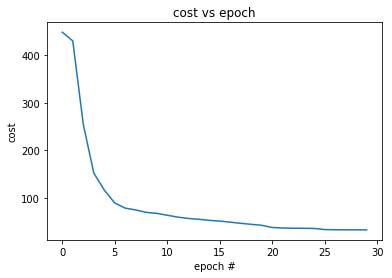

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
final_cost = acosts + acosts2 + acosts3 + acosts4
x_iter = [i for i in range(len(final_cost))]
plt.plot(x_iter,final_cost)
plt.title("cost vs epoch")
plt.xlabel("epoch #")
plt.ylabel("cost")
plt.show()

INFO:tensorflow:Restoring parameters from ../../data/resnet/resnet50.ckpt


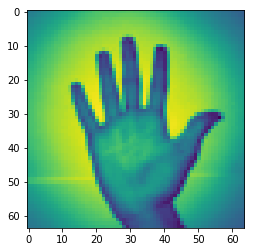

model encoding: [[  5.854834   -8.212554   -3.1507533  -1.6795822 -11.536126   -1.0138131
    7.7193317   3.0066159 -10.73497    14.086089 ]]
actual encoding: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [26]:
aimg = X_test[10]
aimg.shape = (1,64,64,1)
tf.reset_default_graph()
X = tf.placeholder(tf.float32,shape=(None,64,64,1))
Z = forward_pass(X)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver = tf.train.import_meta_graph("../../data/resnet/resnet50.ckpt.meta")
    saver.restore(sess, "../../data/resnet/resnet50.ckpt")
    aZ = sess.run(Z,feed_dict={X:aimg})
    
aimg.shape = (64,64,)
plt.imshow(aimg)
plt.show()
print("model encoding:",aZ)
print("actual encoding:",y_test[10])